In [18]:
from numba import cuda
from numba import *
import numpy as np
from timeit import default_timer as timer
from pylab import imshow, show

In [24]:
@jit
def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

@jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
    
  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      color = mandel(real, imag, iters)
      image[y, x] = color

mandel_gpu = cuda.jit(device=True)(mandel)

@cuda.jit
def mandel_kernel(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height

  startX, startY = cuda.grid(2)
  gridX = cuda.gridDim.x * cuda.blockDim.x;
  gridY = cuda.gridDim.y * cuda.blockDim.y;

  for x in range(startX, width, gridX):
    real = min_x + x * pixel_size_x
    for y in range(startY, height, gridY):
      imag = min_y + y * pixel_size_y 
      image[y, x] = mandel_gpu(real, imag, iters)

Mandelbrot created on GPU in 0.028410 s


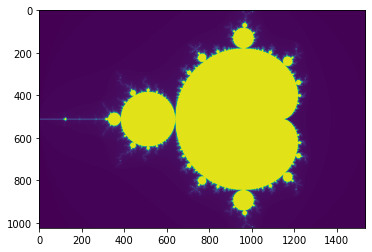

In [37]:
gimage = np.zeros((1024, 1536), dtype = np.uint8)
blockdim = (32, 8)
griddim = (32,16)

start = timer()
d_image = cuda.to_device(gimage)
mandel_kernel[griddim, blockdim](-2.0, 1.0, -1.0, 1.0, d_image, 500) 
d_image.copy_to_host()
dt = timer() - start

print("Mandelbrot created on GPU in %f s" % dt)

imshow(d_image)
show()